In [3]:
BASE_PATH = ""


>

# 1 Import libraries

In [5]:
%pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50, DenseNet169, EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


All done


## Split data into train, valid, test

In [6]:
#train, valid  and test dataframes
train = pd.read_csv("Dataset\\train.csv")
valid = pd.read_csv("Dataset\\valid.csv")
test = pd.read_csv("Dataset\\test.csv")

train["Paths"] = train["Paths"].apply(lambda x: f"{BASE_PATH}{x}")
test["Paths"] = test["Paths"].apply(lambda x: f"{BASE_PATH}{x}")
valid["Paths"] = valid["Paths"].apply(lambda x: f"{BASE_PATH}{x}")
train.Labels.value_counts()
train.head()

,Paths,Labels
0,project_3_dataset/myopia\_189_4324500.jpg,myopia
1,project_3_dataset/cataract\_147_643474.jpg,cataract
2,project_3_dataset/glaucoma\_127_3619862.jpg,glaucoma
3,project_3_dataset/ageDegeneration\_230_1722799...,ageDegeneration
4,project_3_dataset/normal\image1340.png,normal


## C- Data Augmentation

In [7]:
batch_size = 20   # As smaller, As more data generated ....In views of data size
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 48308 validated image filenames belonging to 8 classes.
Found 6038 validated image filenames belonging to 8 classes.
Found 6039 validated image filenames belonging to 8 classes.


## D- Represent a sample

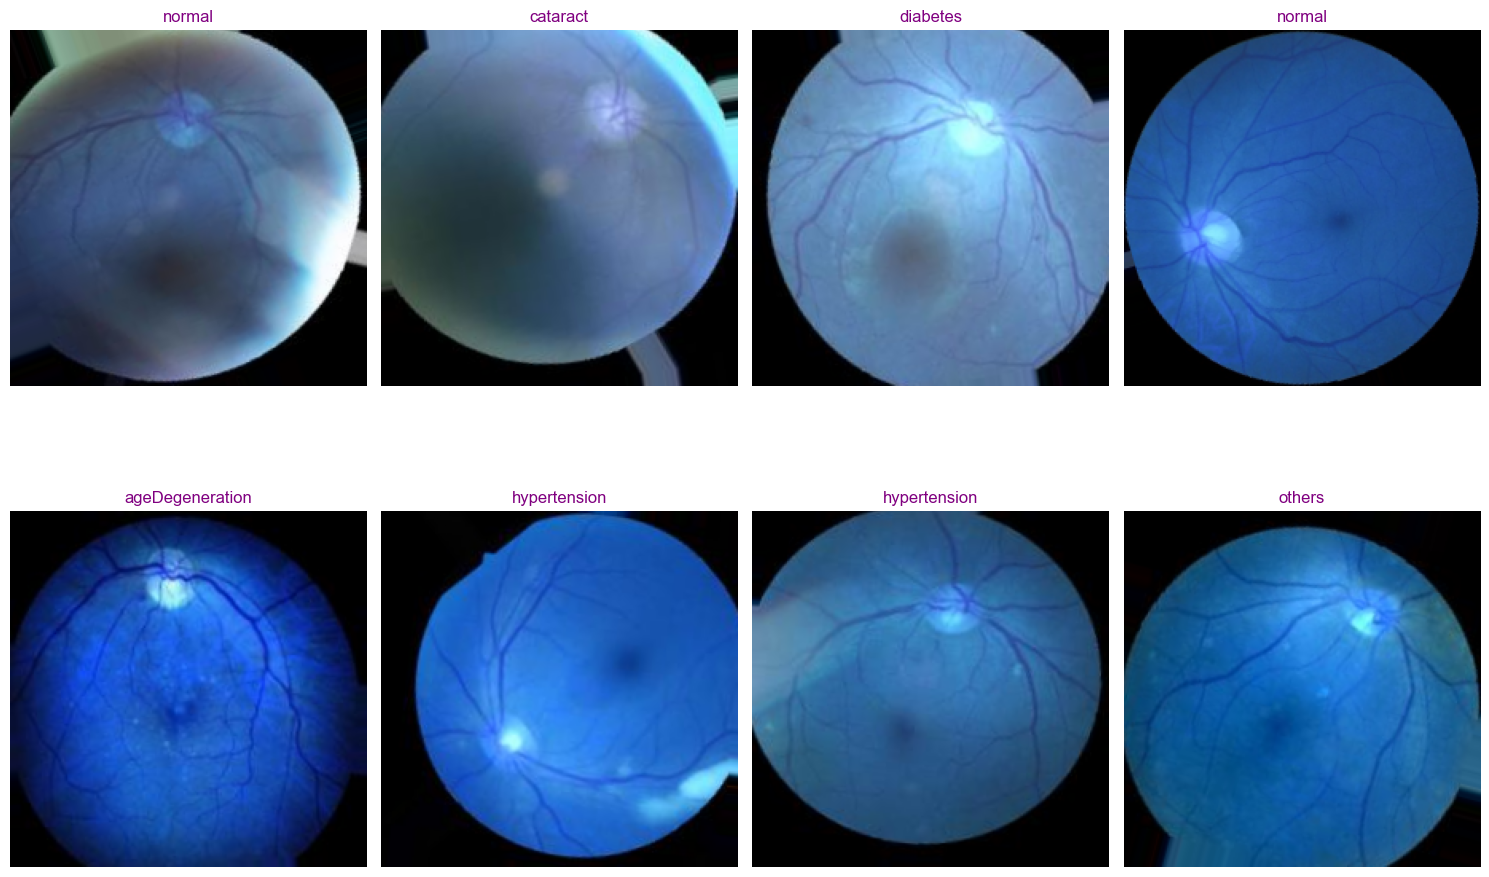

In [8]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)

    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Loading Models

In [9]:
import pickle
# Dictionary to store model names and corresponding model instances
InceptionV3_model = keras.models.load_model("models\\InceptionV3_model.h5")
Xception_model = keras.models.load_model("models\\Xception_model.h5")
ResNet50_model = keras.models.load_model("models\\ResNet50_model.h5")
DenseNet169_model = keras.models.load_model("models\\DenseNet169_model.h5")
VGG16_model = keras.models.load_model("models\\VGG16_model.h5")
VGG19_model = keras.models.load_model("models\\VGG19_model.h5")
EfficientNetB0_model = keras.models.load_model("models\\EfficientNetB0_model.h5")


# c:\Users\shrey\Downloads\EfficientNetB0_model_history.npy
history_InceptionV3 = np.load("histories_numpy\InceptionV3_model_history.npy", allow_pickle=True).item()
history_Xception = np.load("histories_numpy\Xception_model_history.npy", allow_pickle=True).item()
history_ResNet50 = np.load("histories_numpy\ResNet50_model_history.npy", allow_pickle=True).item()
history_DenseNet169 = np.load("histories_numpy\DenseNet169_model_history.npy", allow_pickle=True).item()
history_VGG16 = np.load("histories_numpy\VGG16_model_history.npy", allow_pickle=True).item()
history_VGG19 = np.load("histories_numpy\VGG19_model_history.npy", allow_pickle=True).item()
history_EfficientNetB0 = np.load("histories_numpy\EfficientNetB0_model_history.npy", allow_pickle=True).item()

tr_acc_InceptionV3 = history_InceptionV3['accuracy']
tr_loss_InceptionV3 = history_InceptionV3['loss']
v_acc_InceptionV3 = history_InceptionV3['val_accuracy']
v_loss_InceptionV3 = history_InceptionV3['val_loss']
index_acc_InceptionV3 = np.argmax(v_acc_InceptionV3)
high_Vacc_InceptionV3 = v_acc_InceptionV3[index_acc_InceptionV3]
index_loss_InceptionV3 = np.argmin(v_loss_InceptionV3)
low_Vloss_InceptionV3 = v_loss_InceptionV3[index_loss_InceptionV3]
Epochs_InceptionV3 = list(range(1, len(tr_acc_InceptionV3) + 1))
best_acc_InceptionV3 = f'Best epoch ={str(index_acc_InceptionV3 + 1)}'
best_loss_InceptionV3 = f'Best epoch ={str(index_loss_InceptionV3 + 1)}'

tr_acc_Xception = history_Xception['accuracy']
tr_loss_Xception = history_Xception['loss']
v_acc_Xception = history_Xception['val_accuracy']
v_loss_Xception = history_Xception['val_loss']
index_acc_Xception = np.argmax(v_acc_Xception)
high_Vacc_Xception = v_acc_Xception[index_acc_Xception]
index_loss_Xception = np.argmin(v_loss_Xception)
low_Vloss_Xception = v_loss_Xception[index_loss_Xception]
Epochs_Xception = list(range(1, len(tr_acc_Xception) + 1))
best_acc_Xception = f'Best epoch ={str(index_acc_Xception + 1)}'
best_loss_Xception = f'Best epoch ={str(index_loss_Xception + 1)}'

tr_acc_ResNet50 = history_ResNet50['accuracy']
tr_loss_ResNet50 = history_ResNet50['loss']
v_acc_ResNet50 = history_ResNet50['val_accuracy']
v_loss_ResNet50 = history_ResNet50['val_loss']
index_acc_ResNet50 = np.argmax(v_acc_ResNet50)
high_Vacc_ResNet50 = v_acc_ResNet50[index_acc_ResNet50]
index_loss_ResNet50 = np.argmin(v_loss_ResNet50)
low_Vloss_ResNet50 = v_loss_ResNet50[index_loss_ResNet50]
Epochs_ResNet50 = list(range(1, len(tr_acc_ResNet50) + 1))
best_acc_ResNet50 = f'Best epoch ={str(index_acc_ResNet50 + 1)}'
best_loss_ResNet50 = f'Best epoch ={str(index_loss_ResNet50 + 1)}'

tr_acc_DenseNet169 = history_DenseNet169['accuracy']
tr_loss_DenseNet169 = history_DenseNet169['loss']
v_acc_DenseNet169 = history_DenseNet169['val_accuracy']
v_loss_DenseNet169 = history_DenseNet169['val_loss']
index_acc_DenseNet169 = np.argmax(v_acc_DenseNet169)
high_Vacc_DenseNet169 = v_acc_DenseNet169[index_acc_DenseNet169]
index_loss_DenseNet169 = np.argmin(v_loss_DenseNet169)
low_Vloss_DenseNet169 = v_loss_DenseNet169[index_loss_DenseNet169]
Epochs_DenseNet169 = list(range(1, len(tr_acc_DenseNet169) + 1))
best_acc_DenseNet169 = f'Best epoch ={str(index_acc_DenseNet169 + 1)}'
best_loss_DenseNet169 = f'Best epoch ={str(index_loss_DenseNet169 + 1)}'

tr_acc_VGG16 = history_VGG16['accuracy']
tr_loss_VGG16 = history_VGG16['loss']
v_acc_VGG16 = history_VGG16['val_accuracy']
v_loss_VGG16 = history_VGG16['val_loss']
index_acc_VGG16 = np.argmax(v_acc_VGG16)
high_Vacc_VGG16 = v_acc_VGG16[index_acc_VGG16]
index_loss_VGG16 = np.argmin(v_loss_VGG16)
low_Vloss_VGG16 = v_loss_VGG16[index_loss_VGG16]
Epochs_VGG16 = list(range(1, len(tr_acc_VGG16) + 1))
best_acc_VGG16 = f'Best epoch ={str(index_acc_VGG16 + 1)}'
best_loss_VGG16 = f'Best epoch ={str(index_loss_VGG16 + 1)}'

tr_acc_VGG19 = history_VGG19['accuracy']
tr_loss_VGG19 = history_VGG19['loss']
v_acc_VGG19 = history_VGG19['val_accuracy']
v_loss_VGG19 = history_VGG19['val_loss']
index_acc_VGG19 = np.argmax(v_acc_VGG19)
high_Vacc_VGG19 = v_acc_VGG19[index_acc_VGG19]
index_loss_VGG19 = np.argmin(v_loss_VGG19)
low_Vloss_VGG19 = v_loss_VGG19[index_loss_VGG19]
Epochs_VGG19 = list(range(1, len(tr_acc_VGG19) + 1))
best_acc_VGG19 = f'Best epoch ={str(index_acc_VGG19 + 1)}'
best_loss_VGG19 = f'Best epoch ={str(index_loss_VGG19 + 1)}'


tr_acc_EfficientNetB0 = history_EfficientNetB0['accuracy']
tr_loss_EfficientNetB0 = history_EfficientNetB0['loss']
v_acc_EfficientNetB0 = history_EfficientNetB0['val_accuracy']
v_loss_EfficientNetB0 = history_EfficientNetB0['val_loss']
index_acc_EfficientNetB0 = np.argmax(v_acc_EfficientNetB0)
high_Vacc_EfficientNetB0 = v_acc_EfficientNetB0[index_acc_EfficientNetB0]
index_loss_EfficientNetB0 = np.argmin(v_loss_EfficientNetB0)
low_Vloss_EfficientNetB0 = v_loss_EfficientNetB0[index_loss_EfficientNetB0]
Epochs_EfficientNetB0 = list(range(1, len(tr_acc_EfficientNetB0) + 1))
best_acc_EfficientNetB0 = f'Best epoch ={str(index_acc_EfficientNetB0 + 1)}'
best_loss_EfficientNetB0 = f'Best epoch ={str(index_loss_EfficientNetB0 + 1)}'


# EVALUATION

In [10]:


models = {
    "Inception": InceptionV3_model,
    "Xception": Xception_model,
    "ResNet": ResNet50_model,
    "DenseNet": DenseNet169_model,
    "VGG16": VGG16_model,
    "VGG19": VGG19_model,
    "EfficientNetB0": EfficientNetB0_model
}

# Dictionary to store test results for each model
test_results = {}

# Loop through each model and evaluate it
for model_name, model in models.items():
    # Evaluate the model
    scores = model.evaluate(Test, verbose=1)

    # Store test results in the dictionary
    test_results[model_name] = {
        "accuracy": scores[1],
        "loss": scores[0]
    }

# Print test metrics for each model
for model_name, metrics in test_results.items():
    print(f"\n\n{model_name} Test Metrics:")
    print("  Accuracy:", metrics['accuracy'])
    print("  Loss:", metrics['loss'])


302/302 [==============================] - 188s 616ms/step - loss: 0.1892 - accuracy: 0.9309


Inception Test Metrics:
  Accuracy: 0.5537340641021729
  Loss: 1.2969062328338623


Xception Test Metrics:
  Accuracy: 0.5817188024520874
  Loss: 1.618783950805664


ResNet Test Metrics:
  Accuracy: 0.8450074791908264
  Loss: 0.4625803828239441


DenseNet Test Metrics:
  Accuracy: 0.8430203795433044
  Loss: 0.433268666267395


VGG16 Test Metrics:
  Accuracy: 0.12551747262477875
  Loss: 2.078571081161499


VGG19 Test Metrics:
  Accuracy: 0.13031959533691406
  Loss: 2.078409194946289


EfficientNetB0 Test Metrics:
  Accuracy: 0.9309488534927368
  Loss: 0.18917573988437653


# Let's Visualize it

# 1. InceptionV3

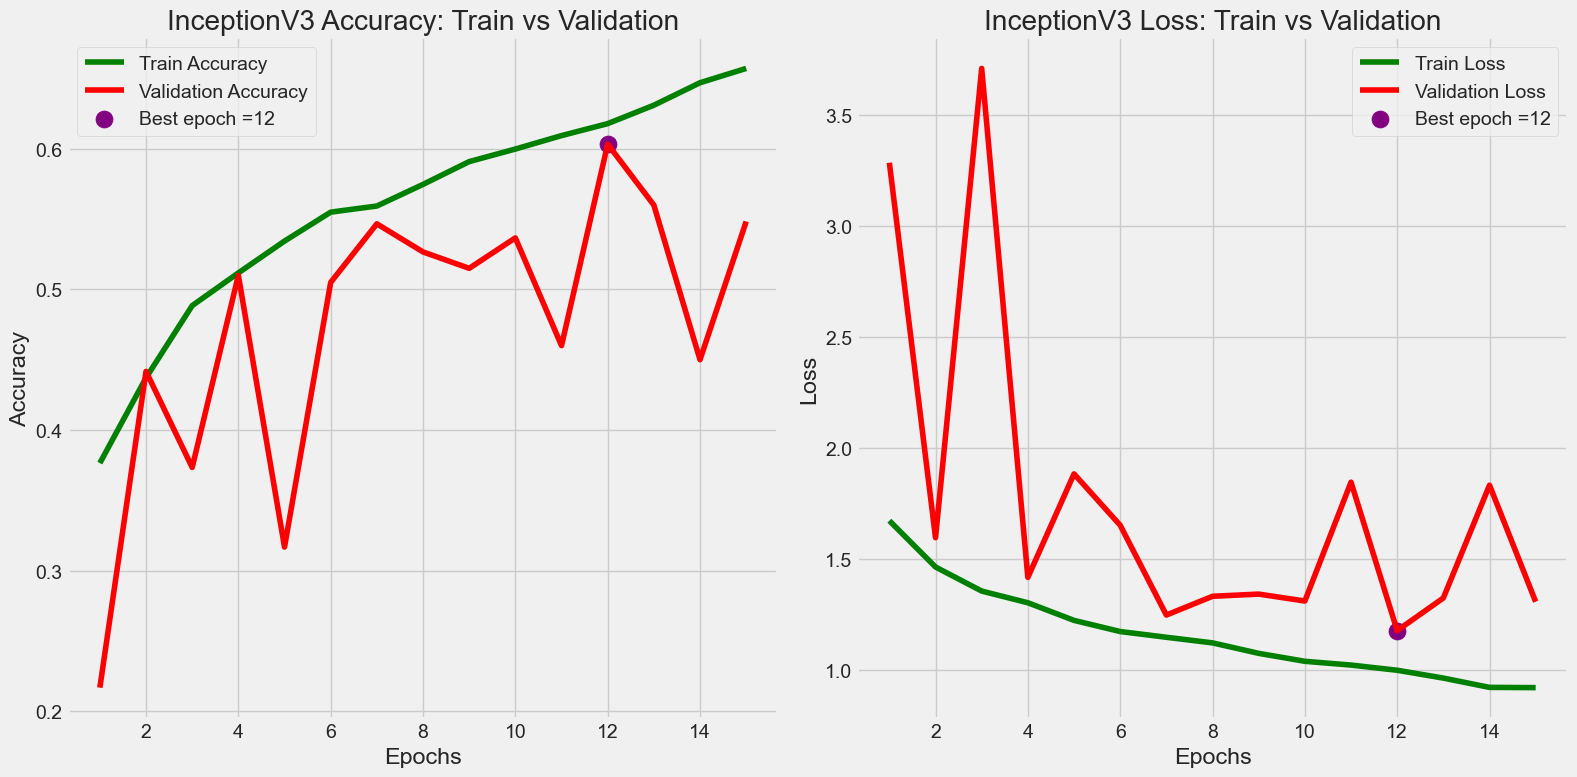

In [12]:
# Plotting for InceptionV3 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_InceptionV3, tr_acc_InceptionV3, "g", label="Train Accuracy")
plt.plot(Epochs_InceptionV3, v_acc_InceptionV3, "r", label="Validation Accuracy")
plt.scatter(index_acc_InceptionV3 + 1, high_Vacc_InceptionV3, s=150, color='purple', label=best_acc_InceptionV3)
plt.title("InceptionV3 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_InceptionV3, tr_loss_InceptionV3, "g", label="Train Loss")
plt.plot(Epochs_InceptionV3, v_loss_InceptionV3, "r", label="Validation Loss")
plt.scatter(index_loss_InceptionV3 + 1, low_Vloss_InceptionV3, s=150, color='purple', label=best_loss_InceptionV3)
plt.title("InceptionV3 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# 2. Xception

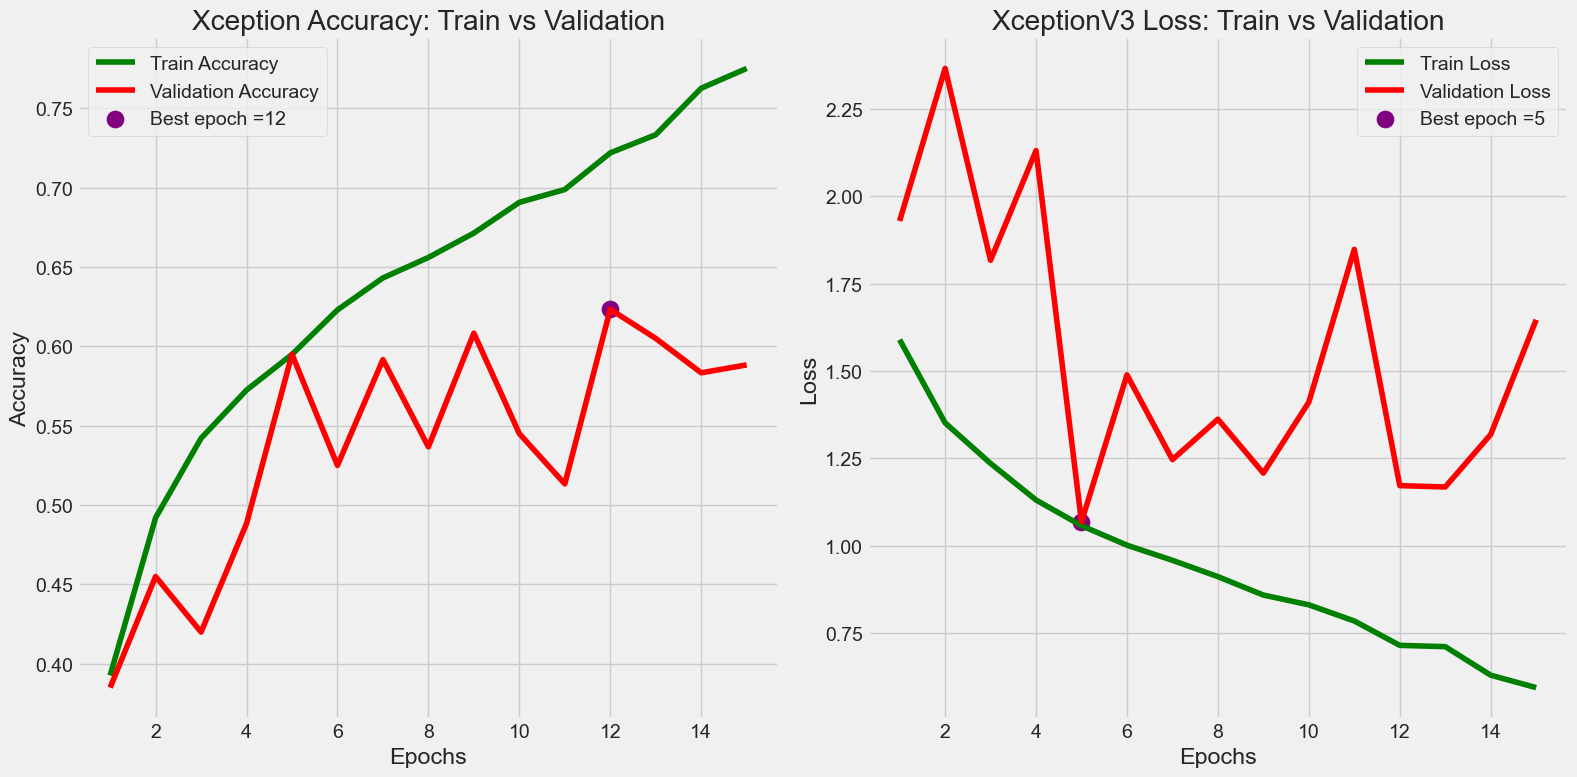

In [13]:
# Plotting for Xception model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_Xception, tr_acc_Xception, "g", label="Train Accuracy")
plt.plot(Epochs_Xception, v_acc_Xception, "r", label="Validation Accuracy")
plt.scatter(index_acc_Xception + 1, high_Vacc_Xception, s=150, color='purple', label=best_acc_Xception)
plt.title("Xception Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_Xception, tr_loss_Xception, "g", label="Train Loss")
plt.plot(Epochs_Xception, v_loss_Xception, "r", label="Validation Loss")
plt.scatter(index_loss_Xception + 1, low_Vloss_Xception, s=150, color='purple', label=best_loss_Xception)
plt.title("XceptionV3 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# 3. VGG16

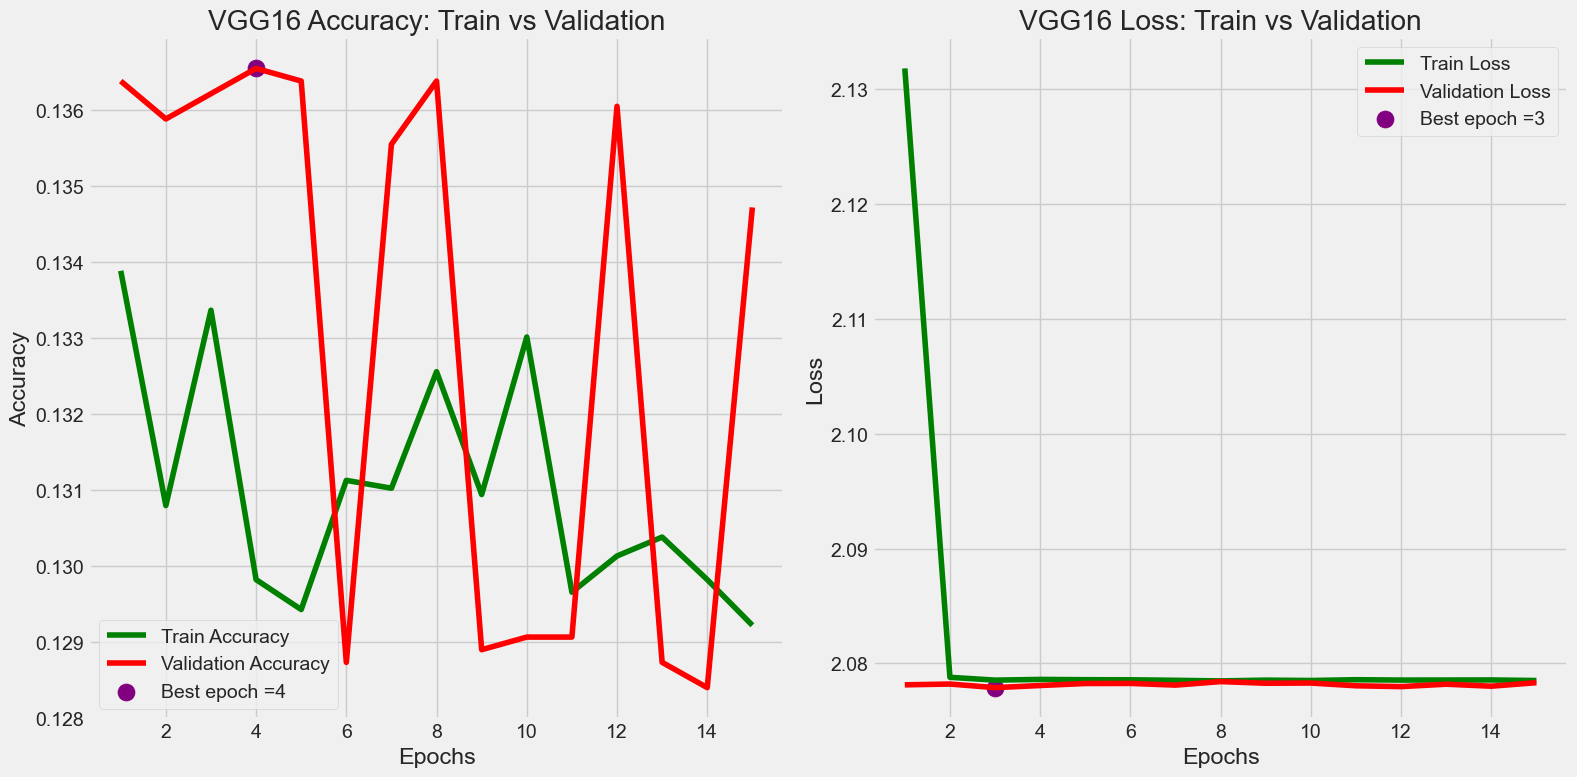

In [14]:
# Plotting for VGG16 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_VGG16, tr_acc_VGG16, "g", label="Train Accuracy")
plt.plot(Epochs_VGG16, v_acc_VGG16, "r", label="Validation Accuracy")
plt.scatter(index_acc_VGG16 + 1, high_Vacc_VGG16, s=150, color='purple', label=best_acc_VGG16)
plt.title("VGG16 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_VGG16, tr_loss_VGG16, "g", label="Train Loss")
plt.plot(Epochs_VGG16, v_loss_VGG16, "r", label="Validation Loss")
plt.scatter(index_loss_VGG16 + 1, low_Vloss_VGG16, s=150, color='purple', label=best_loss_VGG16)
plt.title("VGG16 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# 4. VGG19

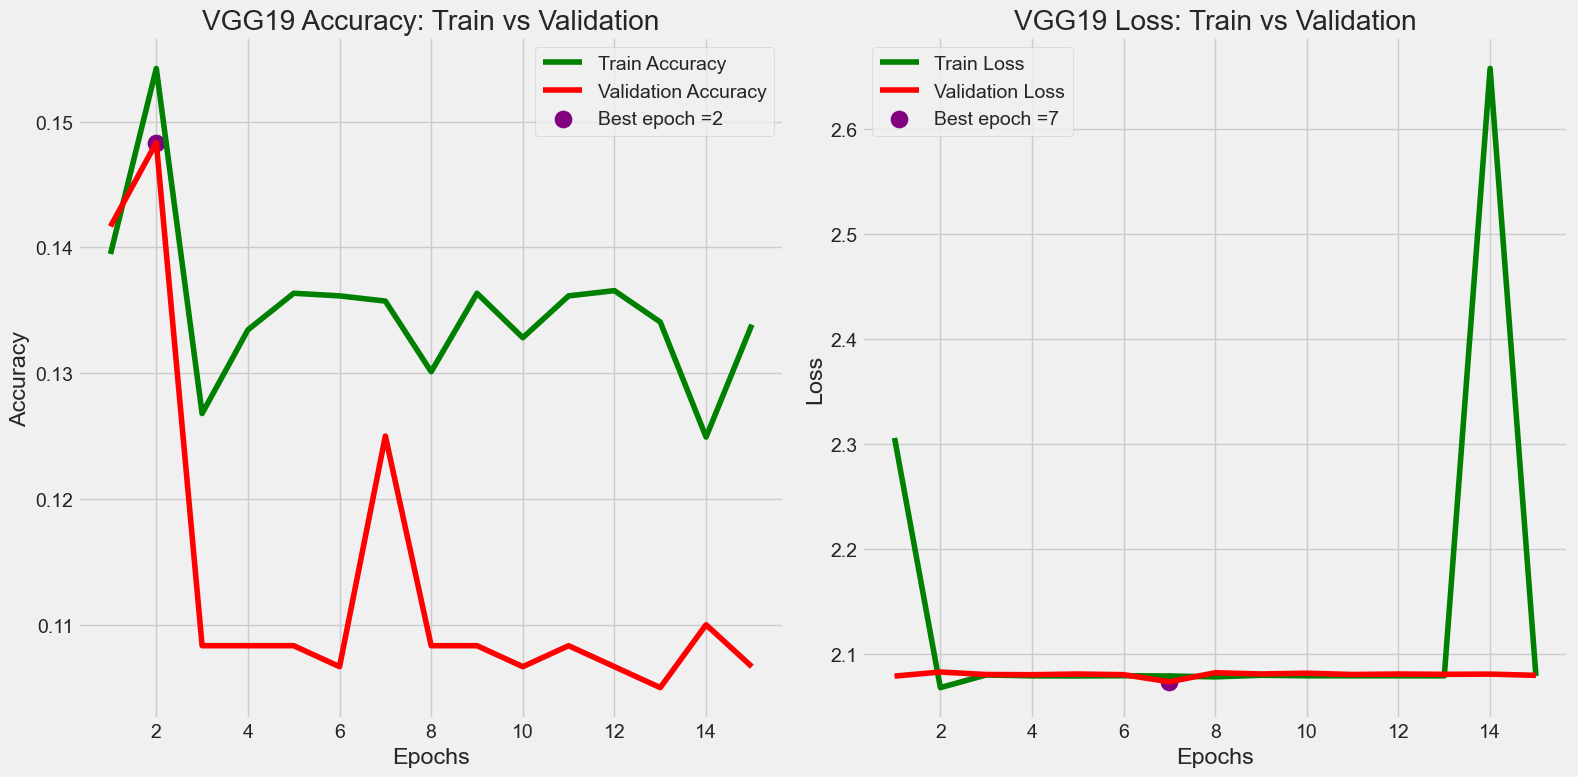

In [15]:
# Plotting for VGG19 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_VGG19, tr_acc_VGG19, "g", label="Train Accuracy")
plt.plot(Epochs_VGG19, v_acc_VGG19, "r", label="Validation Accuracy")
plt.scatter(index_acc_VGG19 + 1, high_Vacc_VGG19, s=150, color='purple', label=best_acc_VGG19)
plt.title("VGG19 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_VGG19, tr_loss_VGG19, "g", label="Train Loss")
plt.plot(Epochs_VGG19, v_loss_VGG19, "r", label="Validation Loss")
plt.scatter(index_loss_VGG19 + 1, low_Vloss_VGG19, s=150, color='purple', label=best_loss_VGG19)
plt.title("VGG19 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



# 5. ResNet50

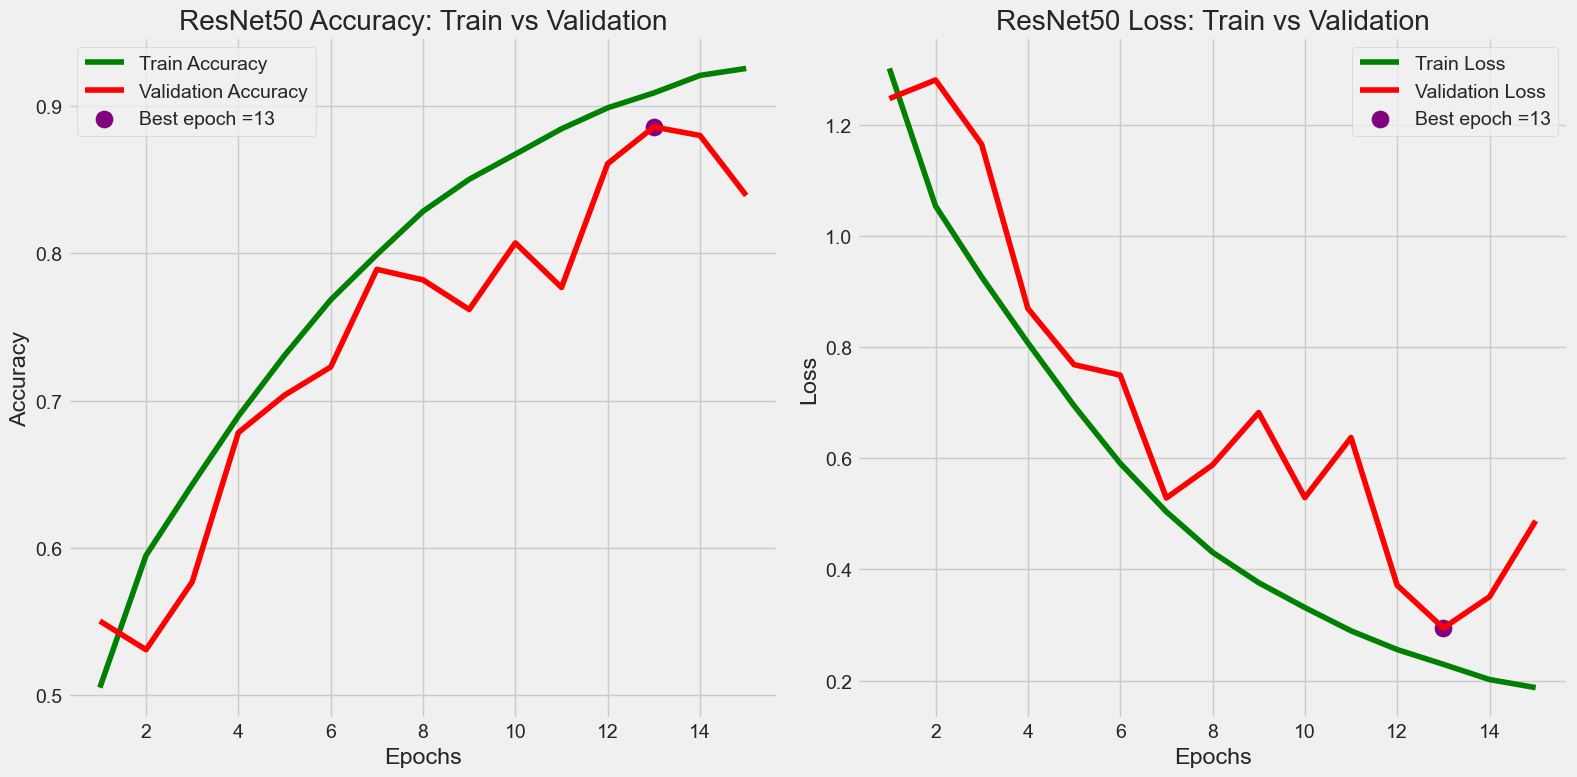

In [16]:

# Plotting for ResNet50 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_ResNet50, tr_acc_ResNet50, "g", label="Train Accuracy")
plt.plot(Epochs_ResNet50, v_acc_ResNet50, "r", label="Validation Accuracy")
plt.scatter(index_acc_ResNet50 + 1, high_Vacc_ResNet50, s=150, color='purple', label=best_acc_ResNet50)
plt.title("ResNet50 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_ResNet50, tr_loss_ResNet50, "g", label="Train Loss")
plt.plot(Epochs_ResNet50, v_loss_ResNet50, "r", label="Validation Loss")
plt.scatter(index_loss_ResNet50 + 1, low_Vloss_ResNet50, s=150, color='purple', label=best_loss_ResNet50)
plt.title("ResNet50 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 6. DenseNet169

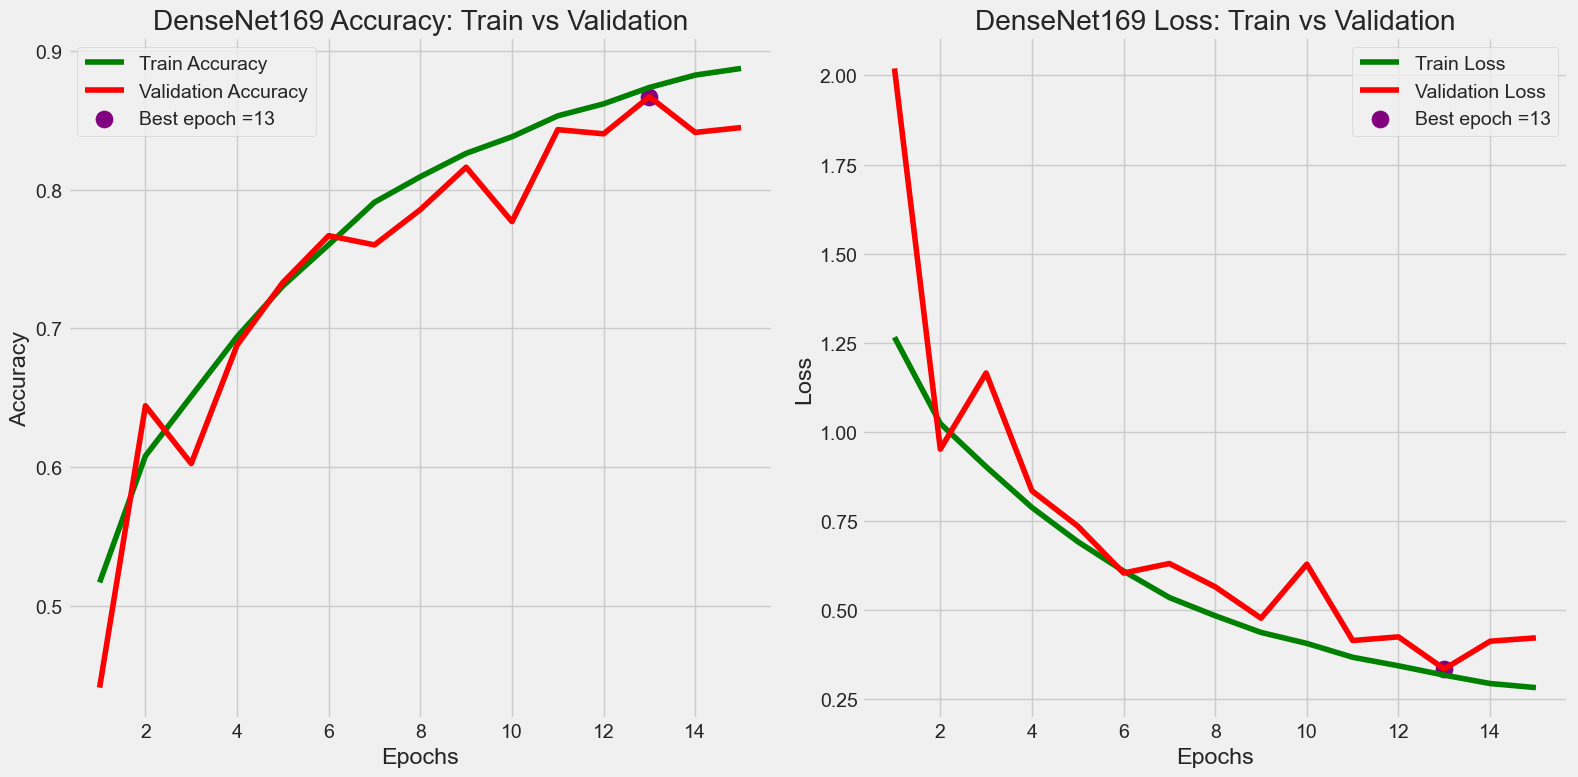

In [17]:
# Plotting for DenseNet169 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_DenseNet169, tr_acc_DenseNet169, "g", label="Train Accuracy")
plt.plot(Epochs_DenseNet169, v_acc_DenseNet169, "r", label="Validation Accuracy")
plt.scatter(index_acc_DenseNet169 + 1, high_Vacc_DenseNet169, s=150, color='purple', label=best_acc_DenseNet169)
plt.title("DenseNet169 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_DenseNet169, tr_loss_DenseNet169, "g", label="Train Loss")
plt.plot(Epochs_DenseNet169, v_loss_DenseNet169, "r", label="Validation Loss")
plt.scatter(index_loss_DenseNet169 + 1, low_Vloss_DenseNet169, s=150, color='purple', label=best_loss_DenseNet169)
plt.title("DenseNet169 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# 7. EfficientNetB0

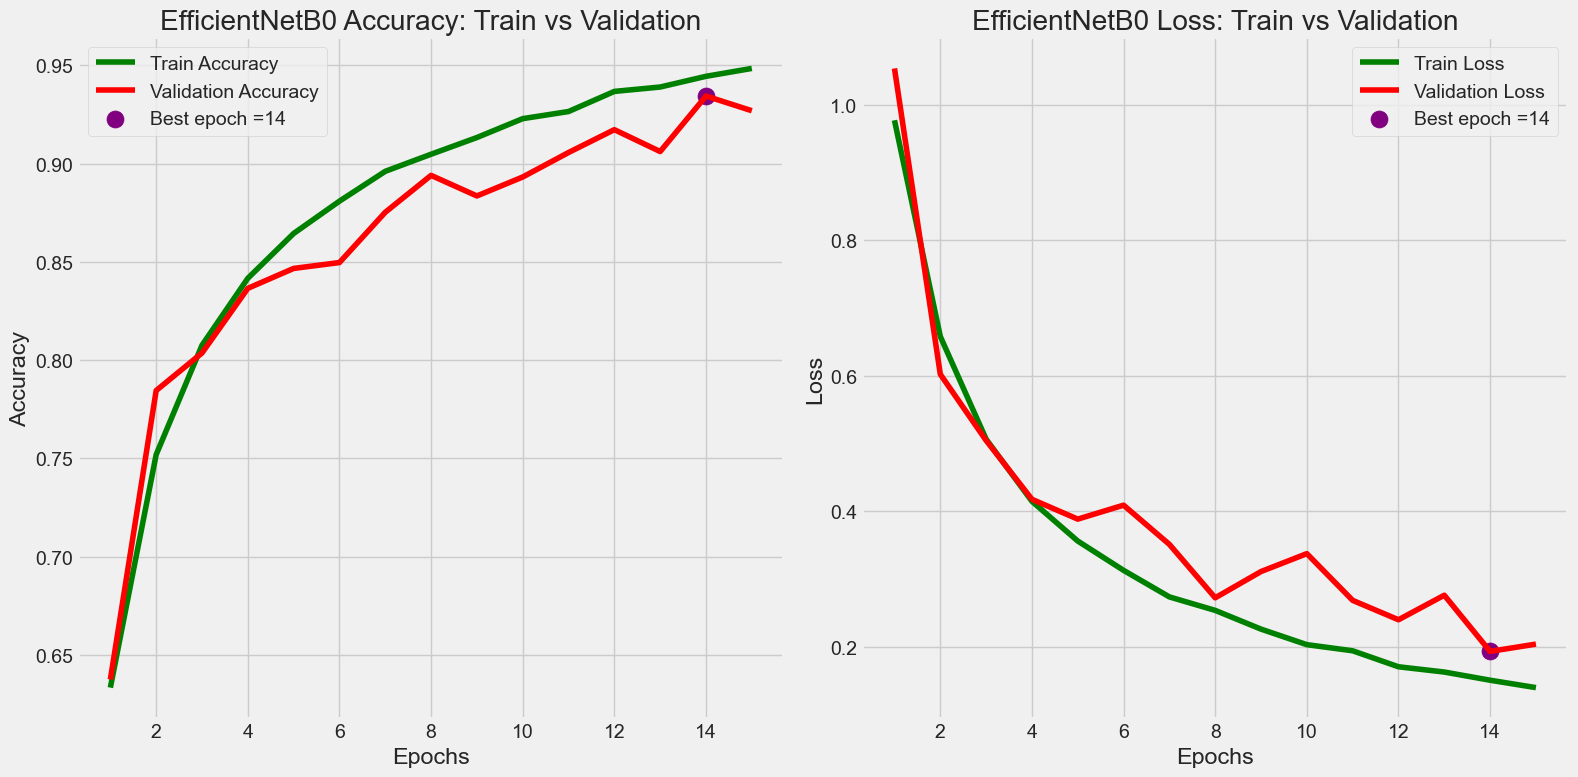

In [18]:
# Plotting for EfficientNetB0B3 model
plt.figure(figsize=(16, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs_EfficientNetB0, tr_acc_EfficientNetB0, "g", label="Train Accuracy")
plt.plot(Epochs_EfficientNetB0, v_acc_EfficientNetB0, "r", label="Validation Accuracy")
plt.scatter(index_acc_EfficientNetB0 + 1, high_Vacc_EfficientNetB0, s=150, color='purple', label=best_acc_EfficientNetB0)
plt.title("EfficientNetB0 Accuracy: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs_EfficientNetB0, tr_loss_EfficientNetB0, "g", label="Train Loss")
plt.plot(Epochs_EfficientNetB0, v_loss_EfficientNetB0, "r", label="Validation Loss")
plt.scatter(index_loss_EfficientNetB0 + 1, low_Vloss_EfficientNetB0, s=150, color='purple', label=best_loss_EfficientNetB0)
plt.title("EfficientNetB0 Loss: Train vs Validation")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Defining Variables

## InceptionV3

In [19]:
# Evaluate InceptionV350 model
test_scores_InceptionV3 = InceptionV3_model.evaluate(Test, verbose=1)

# Print scores for InceptionV350 model
print('InceptionV3 Model Scores:')
print('Test Accuracy:', test_scores_InceptionV3[1])
print('Test Loss:', test_scores_InceptionV3[0])


302/302 [==============================] - 166s 548ms/step - loss: 1.2969 - accuracy: 0.5537
InceptionV3 Model Scores:
Test Accuracy: 0.5537340641021729
Test Loss: 1.2969062328338623


## Xception

In [20]:
# Evaluate Xception model
test_scores_Xception = Xception_model.evaluate(Test, verbose=1)

# Print scores for Xception50 model
print('Xception Model Scores:')
print('Test Accuracy:', test_scores_Xception[1])
print('Test Loss:', test_scores_Xception[0])

302/302 [==============================] - 374s 1s/step - loss: 1.6188 - accuracy: 0.5817
Xception Model Scores:
Test Accuracy: 0.5817188024520874
Test Loss: 1.618783950805664


## VGG16

In [21]:
# Evaluate VGG16 model
test_scores_VGG16 = VGG16_model.evaluate(Test, verbose=1)

# Print scores for VGG16 model
print('VGG16 Model Scores:')
print('Test Accuracy:', test_scores_VGG16[1])
print('Test Loss:', test_scores_VGG16[0])

302/302 [==============================] - 866s 3s/step - loss: 2.0786 - accuracy: 0.1255
VGG16 Model Scores:
Test Accuracy: 0.12551747262477875
Test Loss: 2.078571081161499


## VGG19

In [22]:
# Evaluate VGG19 model
test_scores_VGG19 = VGG19_model.evaluate(Test, verbose=1)

# Print scores for VGG19 model
print('VGG19 Model Scores:')
print('Test Accuracy:', test_scores_VGG19[1])
print('Test Loss:', test_scores_VGG19[0])

302/302 [==============================] - 1057s 3s/step - loss: 2.0784 - accuracy: 0.1303
VGG19 Model Scores:
Test Accuracy: 0.13031959533691406
Test Loss: 2.078409194946289


## ResNet50

In [23]:
# Evaluate ResNet5050 model
test_scores_ResNet50 = ResNet50_model.evaluate(Test, verbose=1)

# Print scores for ResNet5050 model
print('ResNet50 Model Scores:')
print('Test Accuracy:', test_scores_ResNet50[1])
print('Test Loss:', test_scores_ResNet50[0])


302/302 [==============================] - 376s 1s/step - loss: 0.4626 - accuracy: 0.8450
ResNet50 Model Scores:
Test Accuracy: 0.8450074791908264
Test Loss: 0.4625803828239441


## DenseNet169

In [24]:
# Evaluate DenseNet169 model

test_scores_densenet = DenseNet169_model.evaluate(Test, verbose=1)

# Print scores for DenseNet169 model
print('DenseNet169 Model Scores:')
print('Test Accuracy:', test_scores_densenet[1])
print('Test Loss:', test_scores_densenet[0])


302/302 [==============================] - 522s 2s/step - loss: 0.4333 - accuracy: 0.8430
DenseNet169 Model Scores:
Test Accuracy: 0.8430203795433044
Test Loss: 0.433268666267395


## EfficientNetB0

In [25]:
# Evaluate EfficientNetB0 model
test_scores_efficientnet = EfficientNetB0_model.evaluate(Test, verbose=1)

# Print scores for EfficientNetB3 model
print('EfficientNetB3 Model Scores:')
print('Test Accuracy:', test_scores_efficientnet[1])
print('Test Loss:', test_scores_efficientnet[0])


302/302 [==============================] - 240s 794ms/step - loss: 0.1892 - accuracy: 0.9309
EfficientNetB3 Model Scores:
Test Accuracy: 0.9309488534927368
Test Loss: 0.18917573988437653


# Selecting the best model

In [26]:
# Evaluate each model on the test set
test_accs = {
    "InceptionV3_model": InceptionV3_model.evaluate(Test)[1],
    "Xception_model": Xception_model.evaluate(Test)[1],
    "VGG16_model": VGG16_model.evaluate(Test)[1],
    "VGG19_model": VGG19_model.evaluate(Test)[1],
    "ResNet50_model": ResNet50_model.evaluate(Test)[1],
    "DenseNet169_model": DenseNet169_model.evaluate(Test)[1],
    "EfficientNetB0_model": EfficientNetB0_model.evaluate(Test)[1]
}

# Find the model with the highest test accuracy
best_model_name = max(test_accs, key=test_accs.get)
best_test_accuracy = test_accs[best_model_name]

# Print results
print("Test Accuracies:")
for model_name, test_acc in test_accs.items():
    print(model_name + ":", test_acc)
print("\nBest Model Based on Test Accuracy:", best_model_name)
print("Test Accuracy of Best Model:", best_test_accuracy)


302/302 [==============================] - 189s 626ms/step - loss: 0.1892 - accuracy: 0.9309
Test Accuracies:
InceptionV3_model: 0.5537340641021729
Xception_model: 0.5817188024520874
VGG16_model: 0.12551747262477875
VGG19_model: 0.13031959533691406
ResNet50_model: 0.8450074791908264
DenseNet169_model: 0.8430203795433044
EfficientNetB0_model: 0.9309488534927368

Best Model Based on Test Accuracy: EfficientNetB0_model
Test Accuracy of Best Model: 0.9309488534927368


# 5 Get  predictions

In [27]:
from sklearn.metrics import confusion_matrix
import itertools
classes = list(Test.class_indices.keys())
# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "red")
    plt.tight_layout()
    plt.xlabel('Predictions')
    plt.ylabel('Real Values')
    plt.show()




In [28]:
from sklearn.metrics import roc_curve, auc

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred_proba, classes):
    plt.figure(figsize=(8, 6))
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'ROC curve (class {classes[i]}) (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Multiclass')
    plt.legend(loc="lower right")
    plt.show()

# Assuming y_true is the true labels and y_pred_proba is the predicted probabilities
# y_pred_proba should be an array of shape (n_samples, n_classes)
# classes is a list of class labels




In [29]:
models = {
    InceptionV3_model: "InceptionV3",
    Xception_model: "Xception",
    VGG16_model: "VGG16",
    VGG19_model: "VGG19",
    ResNet50_model: "ResNet50",
    DenseNet169_model: "DenseNet169",
    EfficientNetB0_model: "EfficientNetB0"
}


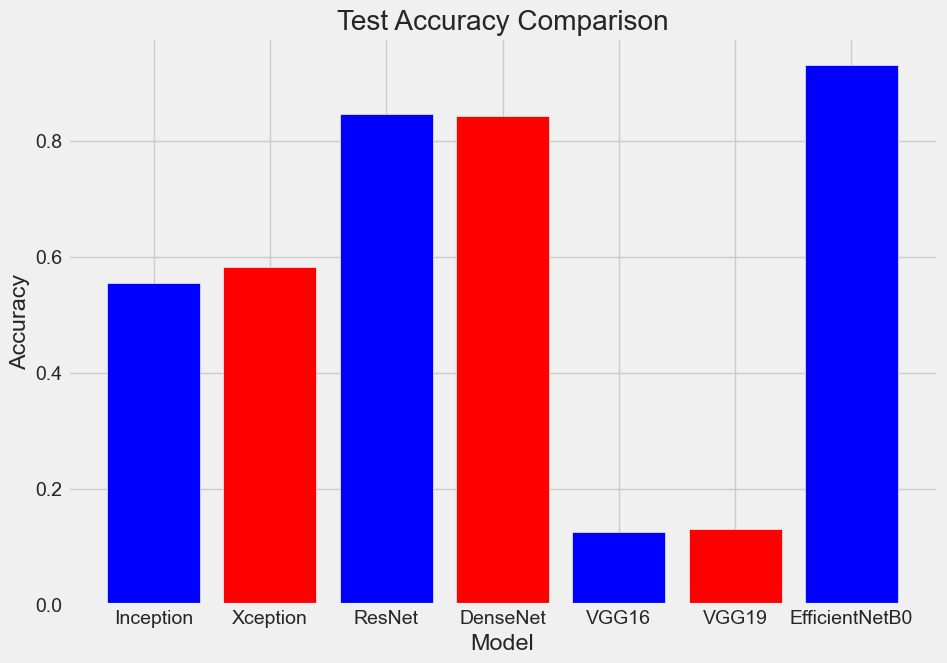

In [37]:
accuracies = [test_results[model_name]["accuracy"] for model_name in test_results]
model_names = list(test_results.keys())

# Create a bar plot
plt.figure(figsize=(10, 7))
plt.bar(model_names, accuracies, color=['blue', 'red'])
plt.title("Test Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()



## Confusion Matrix and Classification Report for InceptionV3

302/302 [==============================] - 291s 947ms/step


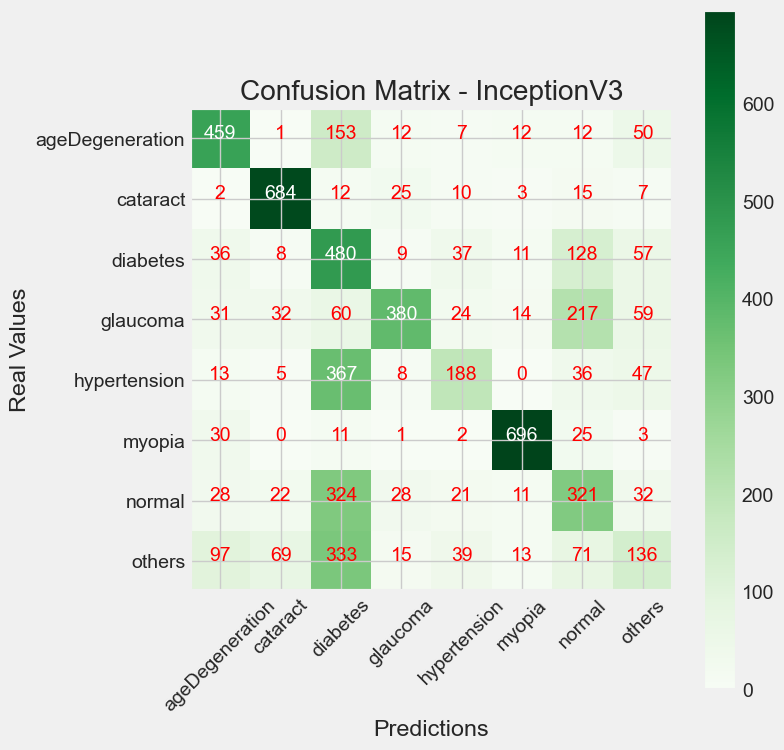

In [30]:
from sklearn.metrics import classification_report
# Get predictions for InceptionV3 model
y_pred_InceptionV3 = InceptionV3_model.predict(Test)

# Calculate confusion matrix for InceptionV3
cm_InceptionV3 = confusion_matrix(Test.classes, np.argmax(y_pred_InceptionV3, axis=1))

# Plot confusion matrix for InceptionV3
plot_confusion_matrix(cm_InceptionV3, classes, title='Confusion Matrix - InceptionV3')

In [39]:
report = classification_report(Test.classes, np.argmax(y_pred_InceptionV3, axis=1), target_names=classes)
print(f"Classification Report - InceptionV3:\n", report)

Classification Report - InceptionV3:
                  precision    recall  f1-score   support

ageDegeneration       0.66      0.65      0.65       706
       cataract       0.83      0.90      0.87       758
       diabetes       0.28      0.63      0.38       766
       glaucoma       0.79      0.47      0.59       817
   hypertension       0.57      0.28      0.38       664
         myopia       0.92      0.91      0.91       768
         normal       0.39      0.41      0.40       787
         others       0.35      0.18      0.23       773

       accuracy                           0.55      6039
      macro avg       0.60      0.55      0.55      6039
   weighted avg       0.60      0.55      0.55      6039



## Confusion Matrix and Classification Report for Xception

302/302 [==============================] - 443s 1s/step


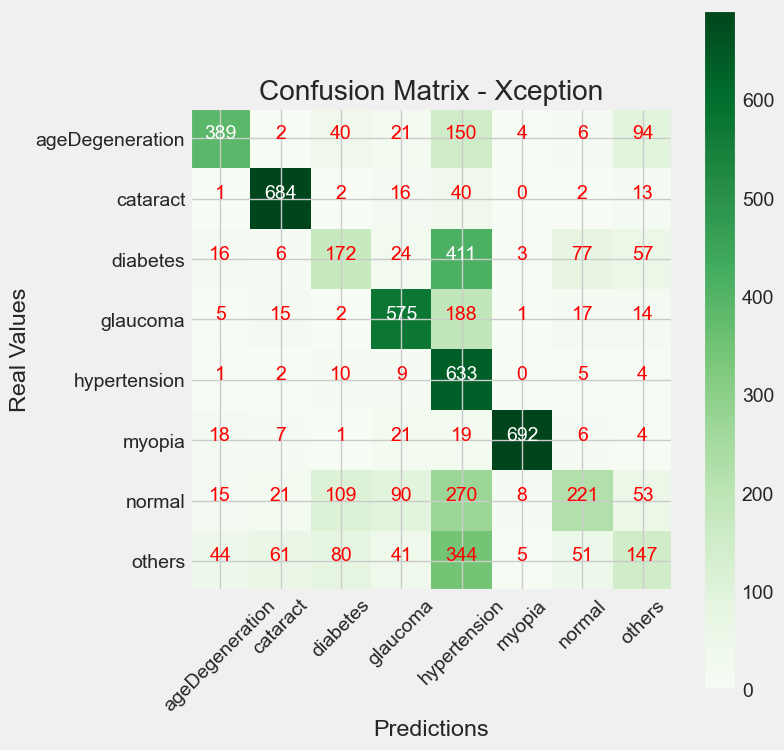

In [31]:
# Get predictions for Xception model
y_pred_Xception = Xception_model.predict(Test)

# Calculate confusion matrix for Xception
cm_Xception = confusion_matrix(Test.classes, np.argmax(y_pred_Xception, axis=1))

# Plot confusion matrix for Xception
plot_confusion_matrix(cm_Xception, classes, title='Confusion Matrix - Xception')

# plot_roc_curve(Test.classes, y_pred_Xception)

In [40]:
report = classification_report(Test.classes, np.argmax(y_pred_Xception, axis=1), target_names=classes)
print(f"Classification Report - Xception:\n", report)

Classification Report - Xception:
                  precision    recall  f1-score   support

ageDegeneration       0.80      0.55      0.65       706
       cataract       0.86      0.90      0.88       758
       diabetes       0.41      0.22      0.29       766
       glaucoma       0.72      0.70      0.71       817
   hypertension       0.31      0.95      0.47       664
         myopia       0.97      0.90      0.93       768
         normal       0.57      0.28      0.38       787
         others       0.38      0.19      0.25       773

       accuracy                           0.58      6039
      macro avg       0.63      0.59      0.57      6039
   weighted avg       0.63      0.58      0.57      6039



## Confusion Matrix and Classification Report for VGG16

302/302 [==============================] - 947s 3s/step


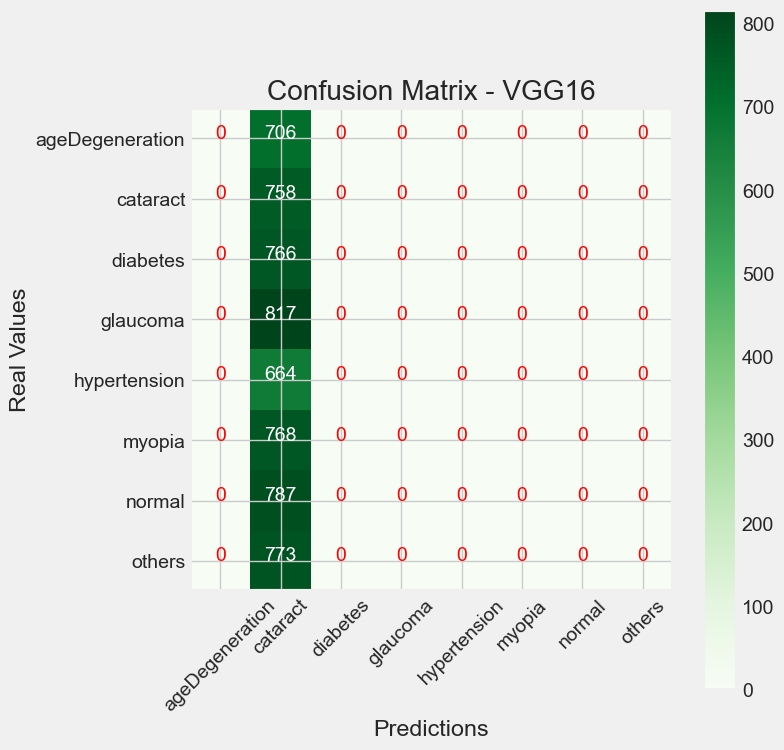

In [32]:
# Get predictions for VGG16 model
y_pred_VGG16 = VGG16_model.predict(Test)

# Calculate confusion matrix for VGG16
cm_VGG16 = confusion_matrix(Test.classes, np.argmax(y_pred_VGG16, axis=1))

# Plot confusion matrix for VGG16
plot_confusion_matrix(cm_VGG16, classes, title='Confusion Matrix - VGG16')

# plot_roc_curve(Test.classes, y_pred_VGG16)

In [41]:
report = classification_report(Test.classes, np.argmax(y_pred_VGG16, axis=1), target_names=classes)
print(f"Classification Report - VGG16:\n", report)

Classification Report - VGG16:
                  precision    recall  f1-score   support

ageDegeneration       0.00      0.00      0.00       706
       cataract       0.13      1.00      0.22       758
       diabetes       0.00      0.00      0.00       766
       glaucoma       0.00      0.00      0.00       817
   hypertension       0.00      0.00      0.00       664
         myopia       0.00      0.00      0.00       768
         normal       0.00      0.00      0.00       787
         others       0.00      0.00      0.00       773

       accuracy                           0.13      6039
      macro avg       0.02      0.12      0.03      6039
   weighted avg       0.02      0.13      0.03      6039



## Confusion Matrix and Classification Report for VGG19

302/302 [==============================] - 1088s 4s/step


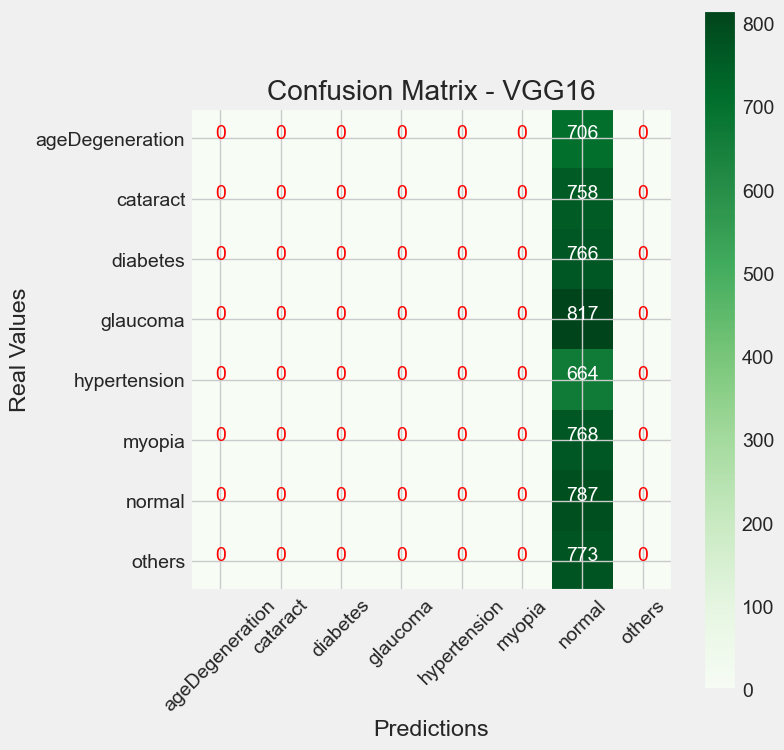

In [33]:
# Get predictions for VGG19 model
y_pred_VGG19 = VGG19_model.predict(Test)

# Calculate confusion matrix for VGG19
cm_VGG19 = confusion_matrix(Test.classes, np.argmax(y_pred_VGG19, axis=1))

# Plot confusion matrix for VGG19
plot_confusion_matrix(cm_VGG19, classes, title='Confusion Matrix - VGG16')

# plot_roc_curve(Test.classes, y_pred_VGG19)

In [42]:
report = classification_report(Test.classes, np.argmax(y_pred_VGG19, axis=1), target_names=classes)
print(f"Classification Report - VGG19:\n", report)

Classification Report - VGG19:
                  precision    recall  f1-score   support

ageDegeneration       0.00      0.00      0.00       706
       cataract       0.00      0.00      0.00       758
       diabetes       0.00      0.00      0.00       766
       glaucoma       0.00      0.00      0.00       817
   hypertension       0.00      0.00      0.00       664
         myopia       0.00      0.00      0.00       768
         normal       0.13      1.00      0.23       787
         others       0.00      0.00      0.00       773

       accuracy                           0.13      6039
      macro avg       0.02      0.12      0.03      6039
   weighted avg       0.02      0.13      0.03      6039



## Confusion Matrix and Classification Report for ResNet50

302/302 [==============================] - 373s 1s/step


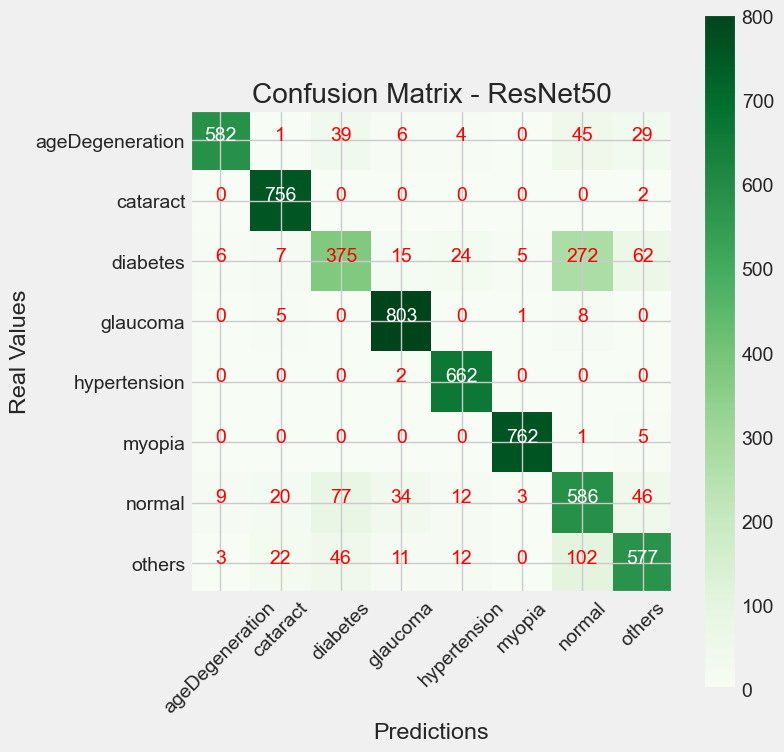

In [34]:
# Get predictions for ResNet50 model
y_pred_resnet = ResNet50_model.predict(Test)

# Calculate confusion matrix for ResNet50
cm_resnet = confusion_matrix(Test.classes, np.argmax(y_pred_resnet, axis=1))

# Plot confusion matrix for ResNet50
plot_confusion_matrix(cm_resnet, classes, title='Confusion Matrix - ResNet50')

# plot_roc_curve(Test.classes, y_pred_resnet)


In [43]:
report = classification_report(Test.classes, np.argmax(y_pred_resnet, axis=1), target_names=classes)
print(f"Classification Report - ResNet50:\n", report)

Classification Report - ResNet50:
                  precision    recall  f1-score   support

ageDegeneration       0.97      0.82      0.89       706
       cataract       0.93      1.00      0.96       758
       diabetes       0.70      0.49      0.58       766
       glaucoma       0.92      0.98      0.95       817
   hypertension       0.93      1.00      0.96       664
         myopia       0.99      0.99      0.99       768
         normal       0.58      0.74      0.65       787
         others       0.80      0.75      0.77       773

       accuracy                           0.85      6039
      macro avg       0.85      0.85      0.84      6039
   weighted avg       0.85      0.85      0.84      6039



## Confusion Matrix and Classification Report for DenseNet169

302/302 [==============================] - 455s 1s/step


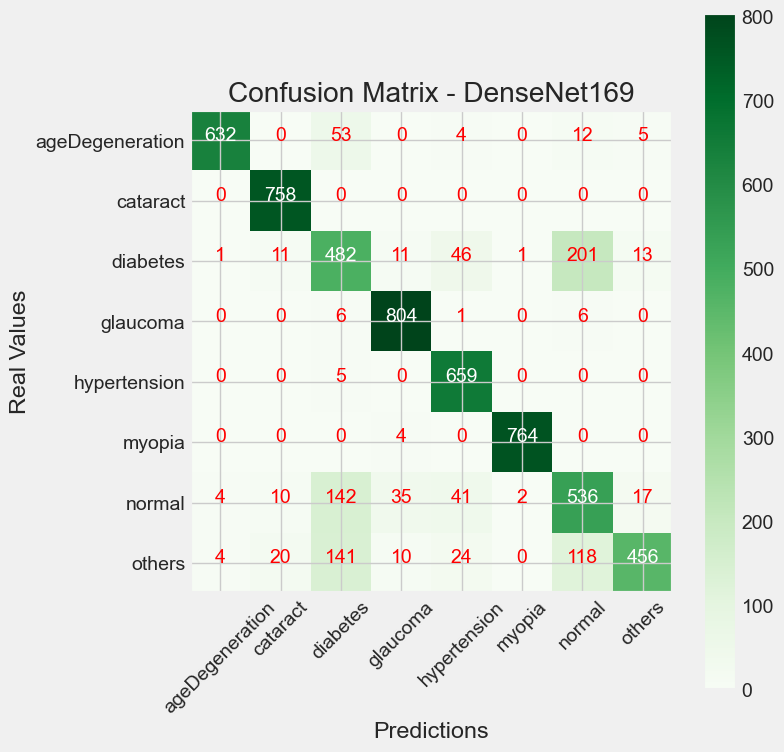

In [35]:
# Get predictions for DenseNet169 model
y_pred_densenet = DenseNet169_model.predict(Test)

# Calculate confusion matrix for DenseNet169
cm_densenet = confusion_matrix(Test.classes, np.argmax(y_pred_densenet, axis=1))

# Plot confusion matrix for DenseNet169
plot_confusion_matrix(cm_densenet, classes, title='Confusion Matrix - DenseNet169')

# plot_roc_curve(Test.classes, y_pred_densenet)


In [44]:
report = classification_report(Test.classes, np.argmax(y_pred_densenet, axis=1), target_names=classes)
print(f"Classification Report - DenseNet169:\n", report)

Classification Report - DenseNet169:
                  precision    recall  f1-score   support

ageDegeneration       0.99      0.90      0.94       706
       cataract       0.95      1.00      0.97       758
       diabetes       0.58      0.63      0.60       766
       glaucoma       0.93      0.98      0.96       817
   hypertension       0.85      0.99      0.92       664
         myopia       1.00      0.99      1.00       768
         normal       0.61      0.68      0.65       787
         others       0.93      0.59      0.72       773

       accuracy                           0.84      6039
      macro avg       0.85      0.85      0.84      6039
   weighted avg       0.85      0.84      0.84      6039



## Confusion Matrix and Classification Report for EfficientNetB0



302/302 [==============================] - 177s 574ms/step


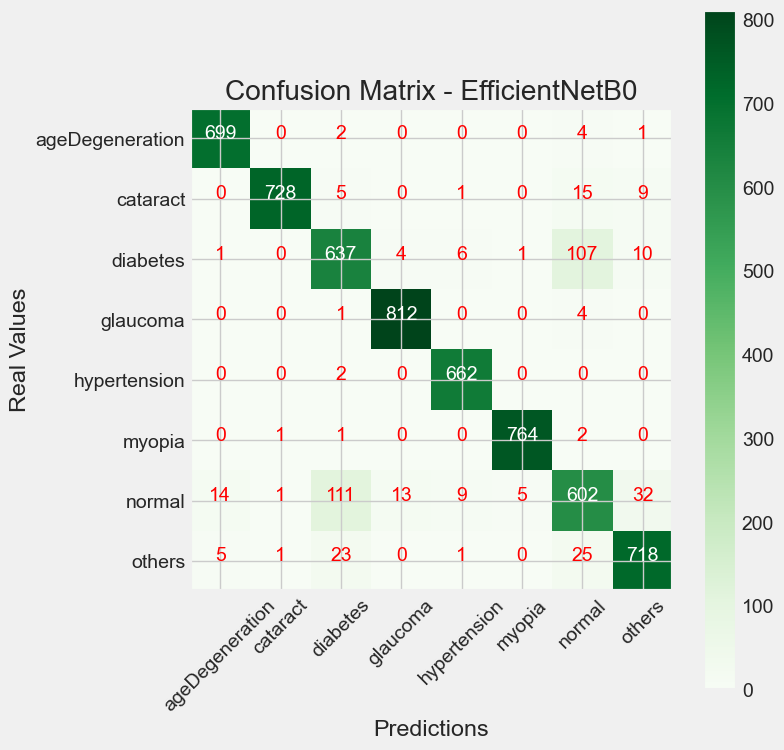

In [36]:
# Get predictions for EfficientNetB0 model
y_pred_efficientnet = EfficientNetB0_model.predict(Test)

# Calculate confusion matrix for EfficientNetB0
cm_efficientnet = confusion_matrix(Test.classes, np.argmax(y_pred_efficientnet, axis=1))

# Plot confusion matrix for EfficientNetB0
plot_confusion_matrix(cm_efficientnet, classes, title='Confusion Matrix - EfficientNetB0')


In [45]:
report = classification_report(Test.classes, np.argmax(y_pred_efficientnet, axis=1), target_names=classes)
print(f"Classification Report - EfficientNetB0:\n", report)

Classification Report - EfficientNetB0:
                  precision    recall  f1-score   support

ageDegeneration       0.97      0.99      0.98       706
       cataract       1.00      0.96      0.98       758
       diabetes       0.81      0.83      0.82       766
       glaucoma       0.98      0.99      0.99       817
   hypertension       0.97      1.00      0.99       664
         myopia       0.99      0.99      0.99       768
         normal       0.79      0.76      0.78       787
         others       0.93      0.93      0.93       773

       accuracy                           0.93      6039
      macro avg       0.93      0.93      0.93      6039
   weighted avg       0.93      0.93      0.93      6039



# 7 Save model

In [ ]:
# # Save InceptionV3 model
# InceptionV3_model.save('InceptionV3_model.h5')

# # Save Xception model
# Xception_model.save('Xception_model.h5')

# # Save VGG16 model
# VGG16_model.save('VGG16_model.h5')

# # Save VGG19 model
# VGG19_model.save('VGG19_model.h5')

# # Save ResNet50 model
# ResNet50_model.save('ResNet50_model.h5')

# # Save DenseNet169 model
# DenseNet169_model.save('DenseNet169_model.h5')

# # Save EfficientNetB0 model
# EfficientNetB0_model.save('EfficientNetB0_model.h5')
